<a href="https://colab.research.google.com/github/pscabral/Prezunic/blob/main/ProjIFMASOFTEX_V01F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset

In [ ]:
# Instalação do TensorFlow (descomente a linha abaixo se o TensorFlow não estiver instalado)
!pip install tensorflow

# Importação de recursos futuros do Python para compatibilidade
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Importação de bibliotecas
import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

# Importações para visualização no IPython
from IPython.display import clear_output, Image, display, HTML

# Importações para aprendizado de máquina com TensorFlow e Keras
import tensorflow as tf
import tensorflow_hub as hub

# Importações adicionais
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# Importações específicas para modelos de redes neurais
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

In [3]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Caminho para o diretório de treinamento das imagens
train_data_dir = '/content/GroceryStoreDataset/dataset/train/Fruit/'

# Definir parâmetros para o pré-processamento das imagens
image_size = (224, 224)
batch_size = 32

# Crie um gerador de dados para treinamento com aumento de dados
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # Usar 20% dos dados para validação

# Crie geradores de dados para treinamento e validação
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')  # Use a porção de treinamento

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')  # Use a porção de validação

# Inicialize o LabelEncoder e ajuste-o aos rótulos de classe do seu conjunto de treinamento
label_encoder = LabelEncoder()
label_encoder.fit(train_generator.classes)

# Salvar as classes em um arquivo numpy
np.save('/content/label_encoder_classes.npy', label_encoder.classes_)

# Crie um modelo baseado na arquitetura InceptionV3 (você pode ajustar a arquitetura conforme necessário)
base_model = InceptionV3(weights='imagenet', include_top=False)

# Adicione camadas personalizadas para classificação
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  # Usar o número de classes

# Crie o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compile o modelo com learning_rate em vez de lr
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Defina callbacks para parar o treinamento prematuramente se a validação não melhorar
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Treine o modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping])

# Caminho para o diretório de teste das imagens
test_data_dir = '/content/GroceryStoreDataset/dataset/test/Fruit/'

# Crie um gerador de dados para teste
test_datagen = ImageDataGenerator(rescale=1./255)

# Crie um gerador de dados de teste
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Avalie o modelo no conjunto de teste
eval_result = model.evaluate(test_generator)

# Exiba a precisão no conjunto de teste
print(f'Acurácia no conjunto de teste: {eval_result[1]*100:.2f}%')

# Salve o modelo treinado
model.save('classification_model.h5')

Found 920 images belonging to 19 classes.
Found 222 images belonging to 19 classes.
87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/30
28/28 [==============================] - 488s 17s/step - loss: 1.5890 - accuracy: 0.5664 - val_loss: 3.3816 - val_accuracy: 0.3750
Epoch 2/30
28/28 [==============================] - 455s 16s/step - loss: 0.3906 - accuracy: 0.9043 - val_loss: 3.1704 - val_accuracy: 0.4896
Epoch 3/30
28/28 [==============================] - 471s 17s/step - loss: 0.1836 - accuracy: 0.9527 - val_loss: 2.7191 - val_accuracy: 0.5312
Epoch 4/30
28/28 [==============================] - 470s 17s/step - loss: 0.0793 - accuracy: 0.9820 - val_loss: 0.8876 - val_accuracy: 0.7344
Epoch 5/30
28/28 [==============================] - 472s 17s/step - loss: 0.0485 - accuracy: 0.9865 - val_loss: 0.6424 - val_accuracy: 0.8177
Epoch 6/30
28/28 [==============================] - 472s 17s/step - loss: 0.0389 - accuracy: 0.9865 - val_loss: 0.3302 - val_accuracy: 0.8906

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
# Avalie o modelo no conjunto de teste
eval_result = model.evaluate(test_generator)

# Exiba a precisão no conjunto de teste
print(f'Acurácia no conjunto de teste: {eval_result[1]*100:.2f}%')

35/35 [==============================] - 128s 4s/step - loss: 1.5853 - accuracy: 0.7171
Acurácia no conjunto de teste: 71.71%


In [5]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Carregue o modelo treinado
model = load_model('/content/classification_model.h5')  # Substitua pelo caminho do seu modelo

# Diretório dos dados de teste
test_data_dir = '/content/GroceryStoreDataset/dataset/test/Fruit'

# Parâmetros para pré-processamento das imagens
image_size = (224, 224)
batch_size = 32

# Crie um gerador de dados para teste
test_datagen = ImageDataGenerator(rescale=1./255)

# Crie um gerador de dados de teste
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Teste no conjunto de teste
test_results = model.evaluate(test_generator)
print(f'Loss no conjunto de teste: {test_results[0]}')
print(f'Acurácia no conjunto de teste: {test_results[1] * 100:.2f}%')

# Realize outros testes aqui, como testes de dados do mundo real, testes de robustez, etc.

# Exemplo de teste em dados do mundo real
# real_world_data_dir = '/caminho/para/seus/dados/do/mundo/real/'
# real_world_datagen = ImageDataGenerator(rescale=1./255)
# real_world_generator = real_world_datagen.flow_from_directory(
#     real_world_data_dir,
#     target_size=image_size,
#     batch_size=batch_size,
#     class_mode='categorical'
# )
# real_world_results = model.evaluate(real_world_generator)
# print(f'Loss em dados do mundo real: {real_world_results[0]}')
# print(f'Acurácia em dados do mundo real: {real_world_results[1] * 100:.2f}%')

# Continue realizando outros testes conforme necessário.

Found 1117 images belonging to 19 classes.
35/35 [==============================] - 132s 4s/step - loss: 1.5853 - accuracy: 0.7171
Loss no conjunto de teste: 1.5852831602096558
Acurácia no conjunto de teste: 71.71%


1/1 [==============================] - 2s 2s/step


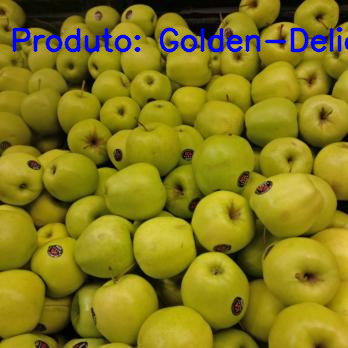

In [6]:
!pip install gTTS
import cv2
import numpy as np
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from gtts import gTTS
import IPython.display as ipd
from google.colab.patches import cv2_imshow
import os

# Carregar o modelo treinado
model = load_model('/content/classification_model.h5')

# Caminho para a imagem de teste (substitua pelo caminho da sua imagem)
caminho_imagem_teste = '/content/GroceryStoreDataset/dataset/test/Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg'

# Ler a imagem de teste
image = cv2.imread(caminho_imagem_teste)

# Redimensionar a imagem para o tamanho esperado pelo modelo
image_resized = cv2.resize(image, (224, 224))

# Pré-processamento específico do InceptionV3
image_preprocessed = preprocess_input(np.expand_dims(image_resized, axis=0))

# Fazer a previsão usando o modelo treinado
predicted_label = model.predict(image_preprocessed)

# Obter o ID da classe prevista
predicted_class_id = np.argmax(predicted_label)

# Obter o nome da classe a partir do caminho da imagem
predicted_class = os.path.basename(os.path.dirname(caminho_imagem_teste))

# Exibir a imagem com a previsão
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(image, f'Produto: {predicted_class}', (10, 50), font, 1, (255, 0, 0), 2, cv2.LINE_AA)
cv2_imshow(image)

# Gerar o arquivo de áudio com o nome do produto previsto
tts = gTTS(text=f'O produto é {predicted_class}', lang='pt')
tts.save('/content/prevision.mp3')

# Reproduzir o arquivo de áudio
ipd.Audio('/content/prevision.mp3')

<IPython.core.display.Javascript object>

1/1 [==============================] - 2s 2s/step


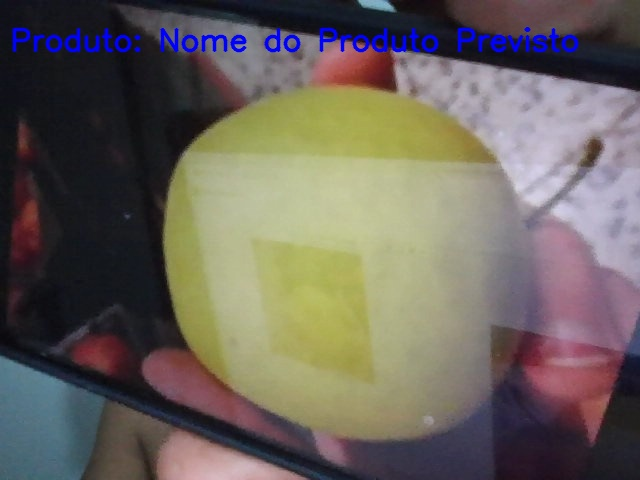

In [40]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

# Carregar o modelo treinado
model = load_model('/content/classification_model.h5')

def capture_and_classify():
    js = Javascript('''
    async function captureImage() {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture Image';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({ video: true });

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture Image to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg');
    }
    ''')

    display(js)
    data = eval_js('captureImage()')
    binary = b64decode(data.split(',')[1])

    # Salvar a imagem temporariamente
    with open('temp.jpg', 'wb') as f:
        f.write(binary)

    # Ler a imagem capturada
    image = cv2.imread('temp.jpg')

    # Redimensionar a imagem para o tamanho esperado pelo modelo
    image_resized = cv2.resize(image, (224, 224))

    # Pré-processamento específico do InceptionV3
    image_preprocessed = preprocess_input(np.expand_dims(image_resized, axis=0))

    # Fazer a previsão usando o modelo treinado
    predicted_label = model.predict(image_preprocessed)

    # Obter o nome do produto previsto
    predicted_product = 'Nome do Produto Previsto'  # Substitua pelo nome real do produto previsto

    # Exibir o nome do produto previsto na imagem
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, f'Produto: {predicted_product}', (10, 50), font, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Salvar a imagem com a previsão em um arquivo temporário
    cv2.imwrite('temp_result.jpg', image)

    # Exibir a imagem com a previsão usando IPython.display
    display(Image(filename='temp_result.jpg'))

    # Remover as imagens temporárias
    import os
    os.remove('temp.jpg')
    os.remove('temp_result.jpg')

capture_and_classify()

In [69]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from pyzbar.pyzbar import decode
import cv2
import numpy as np

def capture_barcode():
    js = Javascript('''
    async function captureBarcode() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg');
    }
    ''')

    display(js)
    data = eval_js('captureBarcode()')
    binary = b64decode(data.split(',')[1])

    # Salvar a imagem temporariamente
    with open('temp.jpg', 'wb') as f:
        f.write(binary)

    # Ler o código de barras na imagem
    image = cv2.imread('temp.jpg', 0)
    decoded_objects = decode(image)
    if decoded_objects:
        for obj in decoded_objects:
            barcode_data = obj.data.decode('utf-8')
            print('Código de barras lido:', barcode_data)
    else:
        print('Nenhum código de barras foi detectado.')

    # Remover a imagem temporária
    import os
    os.remove('temp.jpg')

capture_barcode()


<IPython.core.display.Javascript object>

Nenhum código de barras foi detectado.
